# Location, Production, and Transportation
### Multi-objective optimization example in Decision Analytics for Business and Policy
##### Weighted approach

### Import packages

In [2]:
from gurobipy import *
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

### Set up model parameters

In [3]:
# Warehouse demand in thousands of units
demand = pd.read_csv('demand.csv', index_col=None, header=None).values

# Plant capacity in thousands of units
capacity = [20, 22, 17, 19, 18]

# Fixed costs for each plant
fixedCosts = [12000, 15000, 17000, 13000, 16000]

prodCosts = [45.9, 60.2, 50.0, 35.1, 30.0]

# Transportation costs per thousand units
transportationCosts = pd.read_csv('transportationCost.csv', index_col=None, header=None).values

# Indices for plants and markets
plants = range(len(capacity))
markets = range(len(demand))

### Set up optimization model

Note: here I am showing a slightly different way of formulating the problem than what's done in the slides for this example, showing you more options. The results are computationally and mathematically equivalent.
1. The transportation variables are w[i,j] instead of z[i,j] in this formulation
2. There are two additional decision variables, z1 and z2, that capture the values of the first and the second objective functions

In [3]:
# Setting up model object
m = Model("facility")

### Setting up Decision Variables ###
# Plant open decision variables: x[i] == 1 if plant i is open.
x = m.addVars(plants, vtype=GRB.BINARY)

# production variables
y = m.addVars(plants, lb = 0.0)

# Transportation decision variables: w[i,j] is the
# quantity to transport from plant i to market j
w = m.addVars(plants, markets, lb = 0.0)

# Set up two variables to capture the two objectives 
z1 = m.addVar(lb = 0.0) # for location + production cost
z2 = m.addVar(lb = 0.0) # for transportation cost


setupCost = LinExpr() # facility setup cost
for i in plants:
    setupCost += fixedCosts[i] * x[i]
    
productionCost = LinExpr() # production cost
for i in plants:
    productionCost += prodCosts[i] * y[i]

shipmentCost = LinExpr() # transportation cost
for i in plants:
    for j in markets:
        shipmentCost += transportationCosts[i,j] * w[i,j]
        
m.addConstr(z1 == setupCost + productionCost)
m.addConstr(z2 == shipmentCost)
  
### Constraints ###
# Production and shipment constraints
# Note that the right-hand limit sets the production to zero if the plant
# is closed
for i in plants:
  m.addConstr(sum(w[i,j] for j in markets) <= y[i])
  m.addConstr(y[i] <= capacity[i] * x[i])


# Demand constraints
for j in markets:
  m.addConstr(sum(w[i,j] for i in plants) >= demand[j])

Academic license - for non-commercial use only - expires 2022-09-12
Using license file /Users/yunz2/gurobi.lic


### Weighted Approach

In [4]:
alpha_values = [0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 1]
costs = np.zeros([len(alpha_values), 2])

for iteration in range(len(alpha_values)):
    
    alpha = alpha_values[iteration]
    
    m.setObjective(alpha * z1 + (1 - alpha) * z2, GRB.MINIMIZE)

    
    # Solve
    m.optimize()

            
    # Reporting the breakdown of the cost
    print ("total facility opening cost: ", setupCost.getValue())
    print ("total production cost: ", productionCost.getValue())
    print ("total shipment cost: ", shipmentCost.getValue())
    
    costs[iteration, 0] = z1.x
    costs[iteration, 1] = z2.x

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16 rows, 32 columns and 87 nonzeros
Model fingerprint: 0xdcf254b3
Variable types: 27 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 2e+01]
Presolve removed 7 rows and 12 columns
Presolve time: 0.00s
Presolved: 9 rows, 20 columns, 40 nonzeros
Variable types: 20 continuous, 0 integer (0 binary)

Root relaxation: objective 1.539000e+05, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    153900.00000 153900.000  0.00%     -    0s

Explored 0 nodes (8 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution coun

total facility opening cost:  57000.0
total production cost:  3209.3
total shipment cost:  153900.0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16 rows, 32 columns and 87 nonzeros
Model fingerprint: 0xcf821f7b
Variable types: 27 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [4e-01, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 2e+01]

MIP start from previous solve produced solution with objective 116424 (0.00s)
Loaded MIP start from previous solve with objective 116424

Presolve removed 7 rows and 7 columns
Presolve time: 0.00s
Presolved: 9 rows, 25 columns, 45 nonzeros
Variable types: 20 continuous, 5 integer (5 binary)

Root relaxation: objective 1.120237e+05, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntIn

Presolve time: 0.00s
Presolved: 9 rows, 25 columns, 45 nonzeros
Variable types: 20 continuous, 5 integer (5 binary)

Root relaxation: objective 5.903037e+04, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 59030.3700    0    1 68630.3700 59030.3700  14.0%     -    0s
     0     0     cutoff    0      68630.3700 68630.3700  0.00%     -    0s

Cutting planes:
  Gomory: 1
  MIR: 1
  Flow cover: 1

Explored 1 nodes (16 simplex iterations) in 0.01 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 68630.4 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.863037000000e+04, best bound 6.863037000000e+04, gap 0.0000%
total facility opening cost:  56000.0
total production cost:  3089.3
total shipment cost:  154500.0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical proce

[[ 77299.3 153900. ]
 [ 60209.3 153900. ]
 [ 60209.3 153900. ]
 [ 60209.3 153900. ]
 [ 60209.3 153900. ]
 [ 60209.3 153900. ]
 [ 59089.3 154500. ]
 [ 59089.3 154500. ]
 [ 59089.3 154500. ]
 [ 59089.3 154500. ]
 [ 59089.3 154500. ]
 [ 59089.3 154500. ]
 [ 58726.9 163300. ]
 [ 58726.9 163300. ]
 [ 58726.9 164300. ]]


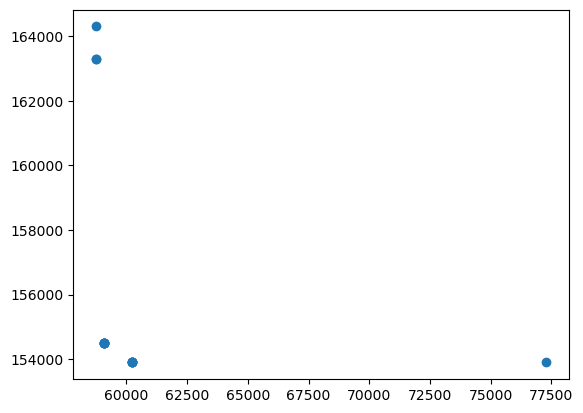

In [5]:
# Plot Pareto frontier
print(costs)
plt.scatter(costs[:,0],costs[:,1])
plt.show()

## Discussion

* We solved 10+ instances of the optimization problem (each with a different value of alpha), how come there are only a handful of points identified as part of the Pareto frontier?
    * Answer Part 1: the feasible region projected to z1-z2 space is polyhedral, i.e., can be constructed by a bunch of line segments. And these points here show only the vertices of the polyhedron. So the boundary identified by the weighted approach actually is everything inbetween the five vertices - a curve with four liner segments.
    * Answer Part 2: In general, every point on that 4-piece curve should be identifiable with some alpha value. But gurobi (and many linear programming solution algorithms) tend to pick vertices over other "intermediate" points. 